In [25]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape, Activation, Dropout
from keras import utils
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, UpSampling2D
from keras.optimizers import Adam, RMSprop

import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [26]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import extract_images, extract_labels

with open('C:/Users/hibat/Desktop/Github/Encoder_Decoder/train-images-idx3-ubyte.gz', 'rb') as f:
      X = extract_images(f)



Extracting C:/Users/hibat/Desktop/Github/Encoder_Decoder/train-images-idx3-ubyte.gz


In [27]:
X[0].shape

(28, 28, 1)

<function matplotlib.pyplot.show(*args, **kw)>

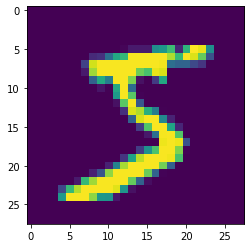

In [28]:

photo_array = np.array(X[0]).reshape(28, 28)
plt.imshow(photo_array)
plt.show

 ![title](images.png)

In [29]:
#create generator
generator_input = Input(shape=(100, ))
print('v')

x1 = Dense(3136)(generator_input)
x1 = BatchNormalization(momentum=0.9)(x1)
x1 = Activation('relu')(x1)

x1 = Reshape((7, 7, 64))(x1)
x1 = UpSampling2D((2, 2))(x1)

x1 = Conv2D(128, kernel_size = (3, 3), padding='same')(x1)
x1 = BatchNormalization(momentum=0.9)(x1)
x1 = Activation('relu')(x1)

x1 = UpSampling2D((2, 2))(x1)
x1 = Conv2D(64, kernel_size=(3, 3), padding='same')(x1)
x1 = BatchNormalization(momentum=0.9)(x1)
x1 = Activation('relu')(x1)

x1 = Conv2D(64, kernel_size=(3, 3), padding='same')(x1)
x1 = BatchNormalization(momentum=0.9)(x1)
x1 = Activation('relu')(x1)

x1 = Conv2D(1, kernel_size=(3, 3), padding='same')(x1)
generator_output = Activation('relu')(x1)

generator_model = Model(inputs = generator_input, outputs=generator_output)

print(generator_model.summary())

v
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_5 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_10 (Activation)   (None, 3136)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 128)       73

In [30]:
#crate discriminator

discriminator_input = Input(shape = (28, 28, 1), name = 'discriminator_input')
print('h')

x = Conv2D(64, kernel_size = (3, 3), strides=(2,2), padding='same')(discriminator_input)
x = Activation('relu')(x)
x = Dropout(0.4)(x)


x = Conv2D(64, kernel_size = (3, 3), strides=(2,2), padding='same')(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)

x = Conv2D(128, kernel_size = (3, 3), strides=(2,2), padding='same')(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)

x = Conv2D(128, kernel_size = (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)

x = Flatten()(x)
discriminator_output = Dense(1, activation='sigmoid')(x)

discriminator_model = Model(inputs=discriminator_input, outputs=discriminator_output)

print(discriminator_model.summary())

h
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
activation_15 (Activation)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
activation_16 (Activation)   (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 64)          0 

In [31]:
# compile discriminator

discriminator_model.compile(optimizer= RMSprop(lr=0.008)
                            , loss = 'binary_crossentropy'
                            , metrics = ['accuracy'])

# compile genrator

model_input = generator_input
model_output = discriminator_model(generator_model(model_input))

model = Model(inputs= model_input, outputs= model_output)
model.compile(optimizer=RMSprop(lr=0.004)
              , loss='binary_crossentropy'
              , metrics=['accuracy'])

print(model.summary())

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_4 (Model)              (None, 28, 28, 1)         515457    
_________________________________________________________________
model_5 (Model)              (None, 1)                 261057    
Total params: 776,514
Trainable params: 769,730
Non-trainable params: 6,784
_________________________________________________________________
None


In [32]:
def train_discriminator(x_train, batch_size):

    valid = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    # TRAIN ON REAL IMAGES
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    true_imgs = x_train[idx]
    
    discriminator_model.train_on_batch(true_imgs, valid) 
    

    # TRAIN ON GENERATED IMAGES
    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator_model.predict(noise)
    
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = 6
    rows = 6
    
    for image in range(len(gen_imgs)):
        gen = gen_imgs[image]
        #gen = cv2.cvtColor(gen, cv2.COLOR_GRAY2RGB)
        gen_img = np.array(gen).reshape(28, 28)
        fig.add_subplot(rows, columns, image + 1)
        plt.axis('off')
        plt.imshow(gen_img)
    plt.show()
        
        
    discriminator_model.train_on_batch(gen_imgs, fake) 
    

def train_generator(batch_size):

    valid = np.ones((batch_size,1))

    noise = np.random.normal(0, 1, (batch_size, 100))
    model.train_on_batch(noise, valid) 
    model.predict(noise)

In [ ]:
epochs = 2000
batch_size = 32

for epoch in range(epochs):
    print('Epochs:', epoch, '\n')
    train_discriminator(X, batch_size)
    train_generator(batch_size)